## Libraries

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd, random, numpy as np

import nltk
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier

from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import difflib
import re
import twitter
import requests

from lxml import html
import bs4
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import os
import pandas as pd, numpy as np, random,string
import matplotlib.pyplot as plt
from gensim.models import word2vec

## 0 - Image maker

In [24]:
# Generate a word cloud image
mask = np.array(Image.open("..."))
str_ = str(pd.read_csv("TEXT_IMG.csv")['0'].iloc[0])

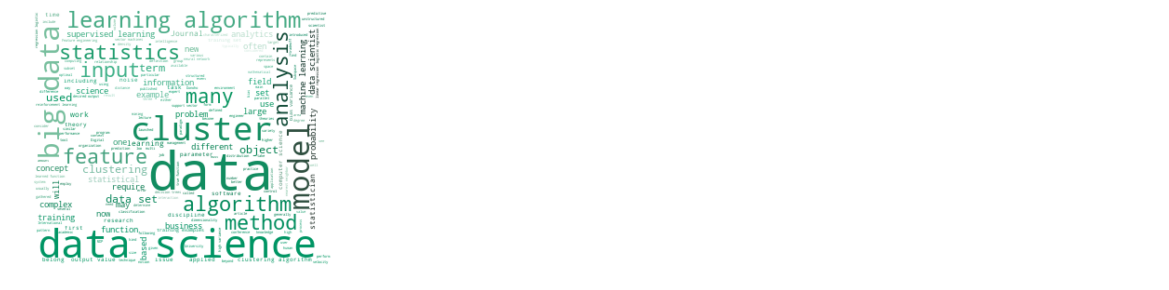

In [36]:
transformed_mask=np.where(mask==0,255,mask)
wordcloud_por = WordCloud( background_color="white", max_words=10000, mask=transformed_mask).generate(str_)
# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[20,20])
plt.imshow(wordcloud_por.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")

# store to file
#plt.savefig("C:\\Users\\Lysis\\Documents\\Python\\BGL_BNP_Paribas_2009_datascience.png", format="png")
plt.show()

## I - Simplified search engine

In [ ]:
#### Initialisation de la base de données
TABLE_TEST = pd.DataFrame({"Text":["M. Doe a acheté deux fondss d'investissement irs et 3 kkr",
                                   "La dette des états souverains...",
                                   "les clients se tournent vers des produits obligataires",
                                   "le client achaeteé& deux fonsds ISRR",
                                   "lorsque je vends monfonds",
                                   "les fonds de privates equities",
                                   "le cristal roederer",
                                   "Cristal d'Arques",
                                   "Le fond crystal"]})
#Choix de la liste de mots à trouver
List_keywords = (["obligations"
           ,"fond crystal"
           ,"actions"
           ,"priv"
           ,"fond"
           ,"cristale"
          ])
ALL=False

#Présentation des résultats
display(TABLE_TEST)
display("--------------------------------------------------------")
for val_keyword in List_keywords:
    display("Research for the word : '{}''".format(val_keyword))
    TABLE_TEST["SELECTION"] = TABLE_TEST.Text.apply(lambda x: x.lower().split(" ")).apply(lambda x: np.sum([np.sum(np.array([difflib.SequenceMatcher(None,j, i).ratio() for i in x])>=0.6) 
                                                                                                for j in val_keyword.lower().split(" ")]+
                                                                                               [np.sum(np.array([difflib.SequenceMatcher(None,val_keyword.lower(), i).ratio() for i in x])>=0.8)]) > 
                                                                             int(np.where(ALL,len(val_keyword.split(" ")),len(val_keyword.split(" "))-1)))
    display(TABLE_TEST[TABLE_TEST["SELECTION"]==True].Text)
    display("--------------------------------------------------------")

## II - Sentiment analysis - based on the library VaderSentiment

## List of sentences
### 1 - "well done" 
### 2 - "things went from bad to worst"
### 3 - "it's raining"
### 4 - "Good, better, best. Never let it rest. Until your good is better and your better is best."

### The goal is to predict the sentiment of the sentences

In [4]:
analyser = SentimentIntensityAnalyzer()
List_sentences =["well done"
                ,"Things went from bad to worst"
                ,"it's raining"
                ,"Good, better, best. Never let it rest. Until your good is better and your better is best."]
for i in List_sentences:
    print("Sentence : '{}' -- Result = '{}'".format(i,
str(np.where(analyser.polarity_scores(i)["neg"] > 0.3,"Negatif", np.where(analyser.polarity_scores(i)["pos"] > 0.3,"Positif","Neutral")))))

Sentence : 'well done' -- Result = 'Positif'
Sentence : 'Things went from bad to worst' -- Result = 'Negatif'
Sentence : 'it's raining' -- Result = 'Neutral'
Sentence : 'Good, better, best. Never let it rest. Until your good is better and your better is best.' -- Result = 'Positif'


## III - Create our own learner and let the algorithm choose which words corresponds to positive sentiment and ~negative sentiment

#### +1 if positive comment 
#### else -1

In [8]:
TEXT_neg = list(pd.read_csv('...\\Quotes_neg.csv', encoding  ='ISO-8859-1')['0'])
TEXT_po = list(pd.read_csv('...\\Quotes.csv', encoding  ='ISO-8859-1', header=-1).rename(columns=dict(zip(range(2),["Quotes","Author","Other"])))["Quotes"])

In [76]:
REPLACE_NO_SPACE = re.compile("[.;:!\'?,\"()\[\]]")
REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)â")
Usless_words = ["â\x93iâ\x92m","â\x94","â\x92","â\x94","Â\x93IÂ\x92m","Â\x92","Â\x94","â\xa0","â"]
REPLACE_OTHERS = re.compile('|'.join(map(re.escape, Usless_words)))
DICO = {"don":"dont","cannot":"cant"," ll":"ll","doesn":"dont"," re":"re", "didn": "didnt","dontt":"dont", "it":"", " ve" :"ve","isn":"isnt","dontot":"dont","didntt":"didnt","wouldn":"wouldnt","wouldntt":"wouldnt"}
DICO_del ={"re":"","ve":"","it":"","you":"", "else":"","isnt":"","cant":"","dont":"",
          "don":"","cannot":""," ll":"","doesn":""," re":"", "didn": "",
           "dontt":"", "":"", " ve" :"","isn":"","dontot":"","didntt":"",
           "wouldn":"","wouldntt":"", "do":"", "they":"",
          "he":"", "she":"", "her":"", "him":"", "can":"","ll":"","higst":"","ga":"","lel":"","dle":"","gets":"","anotr":"","failus":""}
def String_dico(string, dico):
    for i in range(len(dico)):
        string = string.replace(list(dico.keys())[i], list(dico.values())[i])
    return string

def preprocess_reviews(reviews):
    reviews = [REPLACE_OTHERS.sub(" ", line.lower()) for line in reviews]
    reviews = [' '.join(j) for j in [list(set(line.lower().split(" "))-set(stopwords.words('english'))) for line in reviews]]
    reviews = [REPLACE_NO_SPACE.sub(" ", line.lower()) for line in reviews]
    reviews = [REPLACE_WITH_SPACE.sub(" ", line) for line in reviews]
    #reviews = [String_dico(string = line, dico = DICO) for line in reviews]
    reviews = [String_dico(string = line, dico = DICO_del) for line in reviews]
    
    return reviews

TEXT_neg_clean = preprocess_reviews(TEXT_neg)
TEXT_po_clean = preprocess_reviews(TEXT_po)
DATASET = TEXT_neg_clean+TEXT_po_clean

In [77]:
cv = CountVectorizer(binary=True)
cv.fit(DATASET)
X = cv.transform(DATASET)
target = [-1 for i in range(len(TEXT_neg_clean))] + [1 for i in range(len(TEXT_po_clean))]

X_train, X_val, y_train, y_val = train_test_split(
    X, target, train_size = 0.75
)
lr = LogisticRegression()
lr.fit(X_train, y_train)
final_model = LogisticRegression(C=0.05)
final_model.fit(X, target)
#print ("Final Accuracy: %s" 
#      % accuracy_score(target, final_model.predict(X)))
feature_to_coef = {
    word: coef for word, coef in zip(
        cv.get_feature_names(), [round(i,9) for i in final_model.coef_[0]]
    )
}
print("Words that appear in positive sentences")
print("=======================================")
for best_positive in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1], 
    reverse=True)[:10]:
    print (best_positive)
print("---")
print("=======================================")
print("=======================================")
print("Words that appear in kind of negative sentences")
print("=======================================")
for best_negative in sorted(
    feature_to_coef.items(),
    key=lambda x:x[1])[:10]:
    print (best_negative)

Words that appear in positive sentences
('won', 0.024705891)
('people', 2.384e-05)
('one', 1.959e-05)
('success', 1.8954e-05)
('life', 1.4347e-05)
('try', 1.2919e-05)
('good', 1.2829e-05)
('world', 1.1298e-05)
('otrs', 1.1081e-05)
('way', 1.0848e-05)
---
Words that appear in kind of negative sentences
('blow', -0.000279021)
('brighter', -0.000279021)
('shine', -0.000279021)
('make', -0.0002599)
('bear', 8.3e-07)
('solution', 8.3e-07)
('behind', 8.57e-07)
('fearless', 8.57e-07)
('tic', 8.57e-07)
('wins', 8.57e-07)


C:\Users\Lysis\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


## IV - Twitter API

### Retrieve feeds on twitter concerning BNP PARIBAS
#### Language chosen : english
#### Recent tweets

In [9]:
nltk.download('stopwords')
stopWords_en = set(stopwords.words('english'))
stopWords_fr = set(stopwords.words('french'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\WWW\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [11]:
from TwitterAPI import TwitterAPI
consumer_key="..."
consumer_secret="..."
access_token_key="..."
access_token_secret="..."
api = TwitterAPI(consumer_key, consumer_secret, access_token_key, access_token_secret)

In [15]:
wordox_ = "..."
lang ="fr"
r_en = api.request('search/tweets', {'q': wordox_,
        'count': 10000,
        'lang': 'en',
        'result_type':"recent"
        })
r_fr = api.request('search/tweets', {'q': wordox_,
        'count': 10000,
        'lang': 'fr',
        'result_type':"recent"
        })
List_Text = []
if lang=="en":
    for item in r_en.get_iterator():
        if 'text' in item:
            List_Text.append(item['text'])
    List_Text_split = [i.lower() for j in [i.split(" ") for i in List_Text] for i in j]
    L_Text  =[i.replace("\n","").replace('"',"").replace("rt","").replace("(","").replace("…","").replace(".","").replace("“","").replace("!","").replace("?","").replace("”","").replace(".","") for i in List_Text_split if ("http" not in i.lower()) &("@" not in i.lower())&("#" not in i.lower())]
    List_TextF = " ".join([i for i in L_Text])
    
#    for i in stopWords_en:
#        List_Text=List_Text.replace(" "+i+" ","")
else : 
    for item in r_fr.get_iterator():
        if 'text' in item:
            List_Text.append(item['text'])
    List_Text_split = [i for j in [i.split(" ") for i in List_Text] for i in j]
    L_Text  =[i.replace("\n","").replace('"',"").replace("RT","").replace("(","").replace("…","").replace(".","").replace("“","").replace("!","").replace("?","").replace("”","").replace(".","") for i in List_Text_split if ("http" not in i.lower()) &("@" not in i.lower())&("#" not in i.lower())]
    List_TextF = " ".join([i for i in L_Text])
#    for i in stopWords_fr:
#        List_Text=List_Text.replace(" "+i+" ","")
#transformed_mask=np.where(mask==0,255,mask)
#wordcloud_por = WordCloud( background_color="white", max_words=10000, mask=mask).generate(List_TextF)
# create coloring from image
#image_colors = ImageColorGenerator(mask)
#plt.figure(figsize=[20,20])
#plt.imshow(wordcloud_por.recolor(color_func=image_colors), interpolation="bilinear")
#plt.axis("off")

# store to file
#plt.savefig("C:\\Users\\Lysis\\Documents\\Python\\BGL_BNP_Paribas_2009_datascience.png", format="png")
#plt.show()

In [ ]:
List_Text

In [24]:
LIST__ = []
for e in List_Text:
    j = e.split(" ")
    for k in j : 
        k.replace(" ","")
        LIST__.append([k,List_Text.count(k)])

In [25]:
DATACount = pd.DataFrame(pd.DataFrame(LIST__).rename(columns=dict(zip(range(2),['name','count']))).groupby("name")["count"].sum()).sort_values("count", ascending = False)

In [26]:
DATACount

,count
name,
!,0
l'ACC,0
liés,0
le…,0
les…,0
...,...
Réseaux,0
Reste,0
"Renault,",0


## V - Summarizer

In [88]:
#Source : https://github.com/edubey/text-summarizer/blob/master/text-summarizer.py

from nltk.corpus import stopwords
from nltk.cluster.util import cosine_distance
import numpy as np
import networkx as nx
 
def read_article(file_name):
    #file = open(file_name, "r")
    #filedata = file.readlines()
    #article = filedata[0].split(". ")
    article = file_name
    sentences = []

    for sentence in article:
        print(sentence)
        sentences.append(sentence.replace("[^a-zA-Z]", " ").split(" "))
    sentences.pop() 
    
    return sentences

def sentence_similarity(sent1, sent2, stopwords=None):
    if stopwords is None:
        stopwords = []
 
    sent1 = [w.lower() for w in sent1]
    sent2 = [w.lower() for w in sent2]
 
    all_words = list(set(sent1 + sent2))
 
    vector1 = [0] * len(all_words)
    vector2 = [0] * len(all_words)
 
    # build the vector for the first sentence
    for w in sent1:
        if w in stopwords:
            continue
        vector1[all_words.index(w)] += 1
 
    # build the vector for the second sentence
    for w in sent2:
        if w in stopwords:
            continue
        vector2[all_words.index(w)] += 1
 
    return 1 - cosine_distance(vector1, vector2)
 
def build_similarity_matrix(sentences, stop_words):
    # Create an empty similarity matrix
    similarity_matrix = np.zeros((len(sentences), len(sentences)))
 
    for idx1 in range(len(sentences)):
        for idx2 in range(len(sentences)):
            if idx1 == idx2: #ignore if both are same sentences
                continue 
            similarity_matrix[idx1][idx2] = sentence_similarity(sentences[idx1], sentences[idx2], stop_words)

    return similarity_matrix


def generate_summary(file_name, top_n=5):
    stop_words = stopwords.words('english')
    summarize_text = []

    # Step 1 - Read text anc split it
    sentences =  read_article(file_name)

    # Step 2 - Generate Similary Martix across sentences
    sentence_similarity_martix = build_similarity_matrix(sentences, stop_words)

    # Step 3 - Rank sentences in similarity martix
    sentence_similarity_graph = nx.from_numpy_array(sentence_similarity_martix)
    scores = nx.pagerank(sentence_similarity_graph)

    # Step 4 - Sort the rank and pick top sentences
    ranked_sentence = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)    
    print("Indexes of top ranked_sentence order are ", ranked_sentence)    

    for i in range(top_n):
        summarize_text.append(" ".join(ranked_sentence[i][1]))

    # Step 5 - Offcourse, output the summarize texr
    print("Summarize Text: \n", ". ".join(summarize_text))


In [53]:
RQ = requests.get("https://www.businessinsider.com.au/lack-of-sleep-effects-2020-7")
BS4 = bs4.BeautifulSoup(RQ.text, "html.parser")

In [84]:
TXTBS4 = " ".join([re.sub('<[^>]+>', '',str(i).replace("<p>","").replace("</p>","").replace("\'"," ").replace('"',"")) for i in BS4.find_all('p') if str(i).startswith("<p>")][:29])
Clean_TextBS4 = TXTBS4

In [85]:
Clean_TextBS4=Clean_TextBS4.split(".")

In [89]:
generate_summary(Clean_TextBS4, top_n=5)

More than a third of Americans aren’t getting enough sleep, according to the Centres for Disease Control and Prevention
 For optimal health, adults need at least seven hours of sleep each night
 But depending on your age, you might need even more: If you consistently lack sleep, it can pose serious health risks
 In the short-term, staying awake for 17 to 19 hours straight can impair your reaction time as much as a blood-alcohol level of 0
05%, which is considered legally drunk
 Long-term, a consistent lack of sleep may also increase your likelihood for a heart attack or mental illness
 Here are 6 ways a lack of sleep can negatively impact your health: Insufficient sleep can affect your mood and increase your stress levels
 In fact, people with insomnia are 17 times more likely to develop clinical anxiety than people who aren’t sleep deprived
 Non-depressed people who have insomnia may be twice as likely to develop depression than people who sleep well
 This could be due to the impact t